In [1]:
import os
import warnings
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import plotly
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
from random import choices
from string import ascii_lowercase, digits
import datetime
from pathlib import Path
from functools import partial
from itertools import starmap
from dotenv import load_dotenv
import requests

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

import mlflow
from mlflow import MlflowClient
import mlflow.sklearn
from mlflow.models import infer_signature
from mlflow.models import Model
from mlflow.data.pandas_dataset import PandasDataset

# set mlflow traking uri
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.enable_system_metrics_logging()

In [2]:
this_dir = pathlib.Path()
parent_dir = this_dir.resolve().parent
data_dir = this_dir / "matmul-data"

# create results directory, if not already existing
cwd = os.getcwd()
results_dir = os.path.join(cwd, r'matmul_results')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Implement a simple recommender algorithm as linear regression

# Eval and plotting functions

In [3]:
# MODEL EVALUATION FUNCTIONS #

def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2

# Data Prep

hw_dict = {0 : (1,8), 1 : (2,8), 2 : (3,8) : 3 : (4,8), 4 : (8,8)}

In [4]:
# Prepare data
def data_prep(filename='train.csv', features=["size", "sparsity", "min", "max"]):
# Read and log the input data 
    data_filepath = data_dir / filename
    data = pd.read_csv(data_filepath)
    data_artifact = mlflow.data.from_pandas(data)  # log when run is started
    
    
    ## DATA PREPROCESSING STEPS ##
    # remove noisy features 
    feature_cols = data[features]
    df = pd.concat([feature_cols, data['hardware']], axis=1)
    
    print(df.columns)
    # Replace infty values with NaN
    df.replace(['inf', np.inf, -np.inf], np.nan, inplace=True)

    # Impute NaN values with mean
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    sample_data = df.sample(frac=0.25).dropna()
    imp_mean.fit(df)
    df = pd.DataFrame(imp_mean.fit_transform(df), columns = df.columns)
    
    # Encode categorical features
    for col_name in feature_cols.columns.tolist():
        df[col_name] = df[col_name].astype('category').cat.codes
    
    return df, data_artifact

In [5]:
# from scipy.stats import norm

# # calculate the z* for a 90% confidence interval
# confidence_level = 0.9
# alpha = 1-confidence_level
# z_star = norm.ppf(1 - alpha/2)

# z_star

In [6]:
# from scipy.stats import norm

# z = -1
# probability = norm.cdf(z)

# 1 - probability

# Training

In [7]:
## DEFINE MODEL TRAINING FUNCTIONS##
# TODO: Separate preprocessing and training/evaluation

def train_recommender(train, test, experiment_id, seed=None, data_artifact=None, num_epochs=None, autologging=True):
    mlflow.autolog()  # enable autologging
    mlflow.sklearn.autolog()


    # The target column
    train_x = train.drop(["hardware"], axis=1)
    test_x = test.drop(["hardware"], axis=1)
    train_y = train[["hardware"]]
    test_y = test[["hardware"]]
    
    # Normalize data
    train_x_normalized_array, test_x_normalized_array = preprocessing.normalize(train_x, norm="l1"), preprocessing.normalize(test_x, norm="l1")
    train_x, test_x = pd.DataFrame(data=train_x_normalized_array), pd.DataFrame(data=test_x_normalized_array)
    
    train_y_normalized_array, test_y_normalized_array = preprocessing.normalize(train_y, norm="l1"), preprocessing.normalize(test_y, norm="l1")
    train_y, test_y = pd.DataFrame(data=train_y_normalized_array), pd.DataFrame(data=test_y_normalized_array)

    
    ## storage settings ##
    model_type = 'LinearRegression'
    now = datetime.datetime.now().strftime("%Y_%m_%d_%I%M%S%p")
    run_name = model_type + '_' + now
    
    
    ## MLFLOW RUN ##
    # useful for multiple runs
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True, log_system_metrics=True):
        mlflow.sklearn.autolog()
#         e_start = 1.0
#         e_decay = 0.99
        
#         for epoch in range(0, num_epochs):
#             # Decay epsilon
#             epsilon = max(e_start * e_decay, 0)


        # Execute recommender system
        model = LinearRegression()
        model.fit(train_x, train_y)



        # Create model artifact directory
        # cwd = os.getcwd()
        artifacts_dir = os.path.join(results_dir, run_name)
        if not os.path.exists(artifacts_dir):
            os.makedirs(artifacts_dir)
            
            
        # SET AND LOG PARAMETERS # 
        # (some model parameters will be autologged mlflow but not optuna)
        mlflow.log_param("model_seed", seed)
        


        ## IF AUTOLOGGING IS NOT ENABLED ##
        if autologging==False:
            
            # Log and download artifacts locally --- file upload not yet supported in NDP JupyterHub
            active_run = mlflow.active_run()
            mlflow.artifacts.download_artifacts(run_id = active_run.info.run_id, dst_path=artifacts_dir)
            mlflow.sklearn.log_model(sk_model=lr, input_example=test_x, artifact_path=artifacts_dir)
        
       
    # log runtime


    mlflow.end_run()   # END CURRENT RUN BEFORE STARTING NEW RUN

In [8]:
def get_best_model(experiment_id=None):
    
    # Opt. for now: get best run
    best_run = mlflow.search_runs(
        experiment_id, order_by=["metrics.eval_rmse"], max_results=1
    )
    print(best_run.info)
    
    return None

# Run experiments

In [9]:
## EXPERIMENT FUNCTION ##
def run_experiment(num_runs=10, train_func=train_recommender, num_samples=None, num_epochs=None, experiment_name=None):
    
    
    # Generate experiment name
    random_suffix = "".join(choices(ascii_lowercase, k=2)+choices(digits, k=3))
    experiment_name = 'Recommender_'+random_suffix
        
    # create experiment (if not existing)
    try:
        mlflow.create_experiment(experiment_name)
    except:
        pass
    
    mlflow.set_experiment(experiment_name)

    
    # Get experiment ID
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
    
    # prep data
#     df, data_artifact = data_prep(features=["area", "run_max_mem_rss_bytes", "sim_time"])
    train, train_artifact = data_prep(filename='train.csv')
    test, test_artifact = data_prep(filename='test.csv')
    
    # Run experiments on train and test data
    
    for i in range(num_runs):
        # Generate random seed
        #warnings.filterwarnings("ignore")
        np_max_int = np.iinfo(np.int32).max
        seed = np.random.randint(np_max_int)
        np.random.seed(seed)
        
        # train recommender
        train_recommender(train, test, experiment_id, seed=seed, num_epochs=10)
        
    
    
    return experiment_id

In [10]:
experiment = run_experiment(num_runs=10)

Index(['size', 'sparsity', 'min', 'max', 'hardware'], dtype='object')
Index(['size', 'sparsity', 'min', 'max', 'hardware'], dtype='object')


2024/11/08 17:23:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/11/08 17:23:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/11/08 17:23:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/11/08 17:23:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/11/08 17:23:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Hena/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2024/11/08 17:23:43 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/11/08 17:23:43 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics moni

In [11]:
get_best_model(experiment)

<bound method DataFrame.info of                              run_id       experiment_id    status  \
0  e930f824f9c54a18951861e75c4dbd5b  557216878446231064  FINISHED   

                                        artifact_uri  \
0  mlflow-artifacts:/557216878446231064/e930f824f...   

                        start_time                         end_time  \
0 2024-11-09 01:23:55.025000+00:00 2024-11-09 01:23:56.366000+00:00   

   metrics.training_r2_score  metrics.training_root_mean_squared_error  \
0                    0.00022                                  0.399956   

   metrics.training_mean_squared_error  metrics.training_score  ...  \
0                             0.159965                 0.00022  ...   

   params.model_seed params.fit_intercept params.n_jobs tags.estimator_name  \
0         1573232035                 True          None    LinearRegression   

  tags.mlflow.source.type                            tags.mlflow.source.name  \
0                   LOCAL  /Users/Hena/ana

In [12]:
df_runs = mlflow.search_runs(experiment, max_results=10)

In [13]:
rmse = df_runs["metrics.training_root_mean_squared_error"]

In [14]:
df_runs.describe()

,metrics.training_r2_score,metrics.training_root_mean_squared_error,metrics.training_mean_squared_error,metrics.training_score,metrics.training_mean_absolute_error
count,10.00000,10.000000,1.000000e+01,10.00000,1.000000e+01
mean,0.00022,0.399956,1.599649e-01,0.00022,3.199297e-01
std,0.00000,0.000000,2.925695e-17,0.00000,5.851389e-17
min,0.00022,0.399956,1.599649e-01,0.00022,3.199297e-01
25%,0.00022,0.399956,1.599649e-01,0.00022,3.199297e-01
50%,0.00022,0.399956,1.599649e-01,0.00022,3.199297e-01
75%,0.00022,0.399956,1.599649e-01,0.00022,3.199297e-01
max,0.00022,0.399956,1.599649e-01,0.00022,3.199297e-01


In [15]:
df_runs['duration'] = [(df_runs['end_time'][x] - df_runs['start_time'][x]).total_seconds() for x in range(0, df_runs.shape[0])]

<Axes: title={'center': 'RMSE for linear regression model'}>

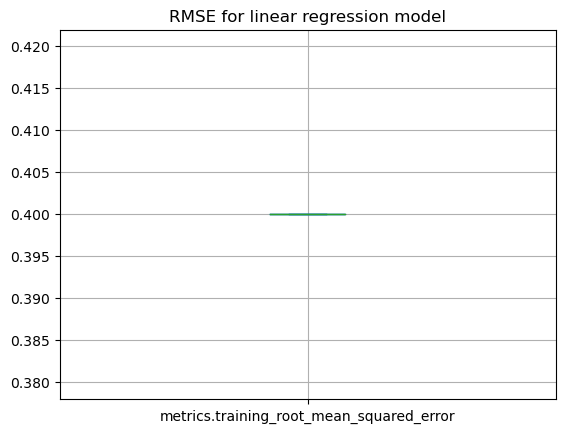

In [16]:
df_runs['metrics.training_root_mean_squared_error'].plot(kind='box', title='RMSE for linear regression model', grid=True) 

<Axes: title={'center': 'Training duration for linear regression model'}>

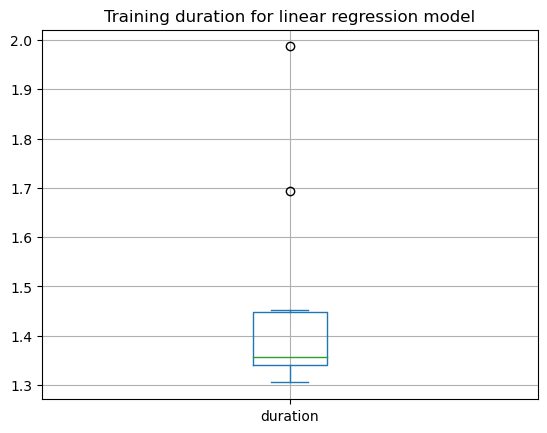

In [17]:
df_runs['duration'].plot(kind='box', title='Training duration for linear regression model', grid=True) 